# Building our own 2D UNet

Here is an example 2D U-Net implementation using minified data based upon creative commons dataset available at https://wiki.cancerimagingarchive.net/display/Public/HNSCC.

In [ ]:
# RAi, machine learning solutions in radiotherapy
# Copyright (C) 2021-2022 Radiotherapy AI Holdings Pty Ltd

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as
# published by the Free Software Foundation, either version 3 of the
# License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.

# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

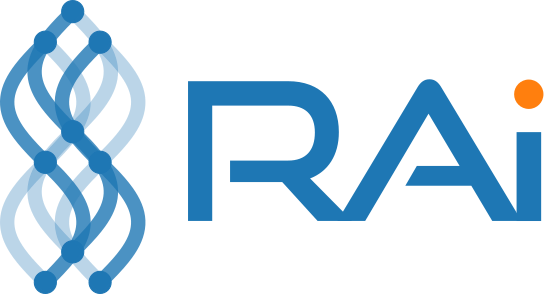

# Disclosure of Conflict of Interest

Simon Biggs, the presenter of this workshop owns Radiotherapy AI which is building an open source autocontouring library from which a Medical Device is being built.

## Overview

* Data pipeline
* The pieces of a UNet
* Training the model

### Library imports

Here are a set of library imports, from both the standard library and some libraries downloadable from PyPI. These are imported within namespaces so as not to variable and function name conflicts.

In [ ]:
import pathlib
import random
import shutil
import urllib.request

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Constants

In [ ]:
BATCH_SIZE = 512
GRID_SIZE = 64

DATASET_TYPES = {"hold-out", "training", "validation"}

COLOURS_AND_LABELS = [
    ("#ff7f0e", "left parotid"),
    ("#2ca02c", "right parotid"),
    ("#d62728", "external"),
]
NUM_CONTOURS = len(COLOURS_AND_LABELS)

In [ ]:
IMAGE_DIMENSIONS = (GRID_SIZE, GRID_SIZE, 1)
MASK_DIMENSIONS = (GRID_SIZE, GRID_SIZE, NUM_CONTOURS)

In [ ]:
EXPECTED_BATCH_IMAGE_DIMENSIONS = (
    BATCH_SIZE,
    *IMAGE_DIMENSIONS,
)
EXPECTED_BATCH_MASK_DIMENSIONS = (
    BATCH_SIZE,
    *MASK_DIMENSIONS,
)

### Download and investigate the data

In [ ]:
zip_url = (
    "https://github.com/RadiotherapyAI/"
    "unet-workshop/releases/download/"
    "mini-parotid/mini-parotid.zip"
)
zip_url

In [ ]:
# Investigate the downloadable data within a filebrowser

In [ ]:
zip_filepath = "data/hnscc.zip"

data_directory = pathlib.Path("data/hnscc")

if not data_directory.exists():
    urllib.request.urlretrieve(zip_url, zip_filepath)
    shutil.unpack_archive(zip_filepath, data_directory)

In [ ]:
dataset_types_found = {
    path.name
    for path in data_directory.glob("*")
    if path.is_dir()
}

assert dataset_types_found == DATASET_TYPES

### Build the TensorFlow pipeline

In [ ]:
def get_image_paths(dataset_type):
    image_paths = list(
        (data_directory / dataset_type).glob(
            "*/*.image.png"
        )
    )

    return image_paths

In [ ]:
def get_path_pairs(dataset_type):
    image_paths = get_image_paths(dataset_type)
    mask_paths = [
        path.parent / f"{path.name.split('.')[0]}.masks.png"
        for path in image_paths
    ]

    path_pairs = [
        (str(image), str(mask))
        for image, mask in zip(
            image_paths,
            mask_paths,
        )
    ]

    return sorted(path_pairs)

In [ ]:
@tf.function
def load(path_pair):
    image_path = path_pair[0]
    masks_path = path_pair[1]

    image_raw = tf.io.read_file(image_path)
    image = tf.io.decode_image(
        image_raw, channels=1, dtype=tf.uint8
    )

    masks_raw = tf.io.read_file(masks_path)
    masks = tf.io.decode_image(
        masks_raw, channels=NUM_CONTOURS, dtype=tf.uint8
    )

    return image / 255, masks / 255

In [ ]:
def create_datasets(dataset_type):
    path_pairs = get_path_pairs(dataset_type)
    dataset = tf.data.Dataset.from_tensor_slices(path_pairs)
    dataset = dataset.shuffle(
        len(path_pairs),
        reshuffle_each_iteration=True,
    )
    dataset = dataset.map(load)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
datasets = {}

for dataset_type in DATASET_TYPES:
    datasets[dataset_type] = create_datasets(dataset_type)

datasets

### Plotting the pipeline

In [ ]:
iterator = iter(datasets["validation"])

In [ ]:
batch_validation_images, batch_validation_masks = next(iterator)

In [ ]:
batch_validation_images.shape

In [ ]:
batch_validation_masks.shape

In [ ]:
image = batch_validation_images[0, ...]
masks = batch_validation_masks[0, ...]

In [ ]:
image.shape

In [ ]:
masks.shape

In [ ]:
plt.imshow(image[:, :, 0])

In [ ]:
plt.imshow(image[:, :, 0], cmap='gray')

In [ ]:
plt.imshow(masks)

In [ ]:
plt.contour(masks[..., 0], levels=[0.5])

In [ ]:
plt.imshow(image[:, :, 0], cmap='gray')
plt.contour(masks[..., 0], levels=[0.5], colors=[COLOURS_AND_LABELS[0][0]])
plt.axis('equal')

In [ ]:
# Try and generalise the above, and see if I can get the same result

i = 0

plt.imshow(image[:, :, 0], cmap='gray')
plt.contour(masks[..., i], levels=[0.5], colors=[COLOURS_AND_LABELS[i][0]])
plt.axis('equal')

In [ ]:
i = 1

plt.imshow(image[:, :, 0], cmap='gray')
plt.contour(masks[..., i], levels=[0.5], colors=[COLOURS_AND_LABELS[i][0]])
plt.axis('equal')

In [ ]:
i = 2

plt.imshow(image[:, :, 0], cmap='gray')
plt.contour(masks[..., i], levels=[0.5], colors=[COLOURS_AND_LABELS[i][0]])
plt.axis('equal')

In [ ]:
# Turn this into a re-usable function

def plot_contours(ax, image, masks):
    ax.imshow(image[:, :, 0], cmap="gray")

    for i, (colour, label) in enumerate(COLOURS_AND_LABELS):
        if np.all(masks[..., i] < 0.5) or np.all(
            masks[..., i] > 0.5
        ):
            continue

        c = ax.contour(
            masks[..., i],
            colors=[colour],
            levels=[0.5],
        )
        c.collections[0].set_label(label)

    ax.axis("equal")
    ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_contours(ax, image, masks)

### UNet Diagram

In this section we will create a Tensorflow Keras 2D UNet model utilising a set of pre-built functions. An example UNet diagram is given below for aiding explanation:

![](https://github.com/RadiotherapyAI/unet-workshop/blob/019f25013030e51b83e2370b347bf5933aebc37c/images/unet.png?raw=1)

### Activation

In [ ]:
def activation(x):
    x = tf.keras.layers.Activation("relu")(x)

    return x

In [ ]:
activation(10).numpy()

In [ ]:
activation(-5).numpy()

In [ ]:
x = np.linspace(-10, 10, 200)
y = activation(x).numpy()

plt.plot(x, y)
plt.title('Relu Activiation')

"A large number of linear combinations of linear equations, can be reduced to a single linear equation".

RELU "breaks" the linearity. And enables "deep" learning.

### Convolution

In [ ]:
def array_image(array, vmin=-1, vmax=1):
    plt.imshow(array, vmin=vmin, vmax=vmax)

    for (j,i), label in np.ndenumerate(array):
        plt.text(i, j, np.round(label, decimals=2), ha='center', va='center')
        
    plt.colorbar()

In [ ]:
x = np.zeros(shape=(1,7,7,1))
x[0,2,4,0] = 1

array_image(x[0, :, :, 0])

In [ ]:
example_convolution = tf.keras.layers.Conv2D(
    filters=1,
    kernel_size=3,
    padding="same",
    kernel_initializer="he_normal",
)

In [ ]:
y = example_convolution(x)

In [ ]:
# Kernel
example_convolution.weights[0].shape

In [ ]:
# Bias
example_convolution.weights[1].shape

In [ ]:
kernel = example_convolution.weights[0][..., 0, 0]
array_image(kernel)

In [ ]:
array_image(y[0,...,0])

In [ ]:
z = example_convolution(y).numpy()
array_image(z[0,...,0])

### Pooling

In [ ]:
example_max_pool = tf.keras.layers.MaxPool2D()

In [ ]:
z.shape

In [ ]:
pooled_z = example_max_pool(z).numpy()

In [ ]:
pooled_z.shape

In [ ]:
array_image(z[0,...,0])

In [ ]:
array_image(pooled_z[0,...,0])

### Convolutional Transpose

In [ ]:
example_convolution_transpose = tf.keras.layers.Conv2DTranspose(
    filters=1,
    kernel_size=3,
    strides=2,
    padding="same",
    kernel_initializer="he_normal",
)

In [ ]:
x.shape

In [ ]:
array_image(x[0, ..., 0])

In [ ]:
y = example_convolution_transpose(x).numpy()

In [ ]:
y.shape

In [ ]:
kernel = example_convolution_transpose.weights[0][..., 0, 0]
array_image(kernel)

In [ ]:
plt.figure(figsize=(12, 8))
array_image(y[0, ..., 0])

### Putting it all together

In [ ]:
def convolution(x, number_of_filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(
        number_of_filters,
        kernel_size,
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    return x



def conv_transpose(x, number_of_filters, kernel_size=3):
    x = tf.keras.layers.Conv2DTranspose(
        number_of_filters,
        kernel_size,
        strides=2,
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    return x

In [ ]:
def encode(
    x,
    number_of_filters,
    number_of_convolutions=2,
):
    """An encoding layer within a 2D UNet"""
    for _ in range(number_of_convolutions):
        x = convolution(x, number_of_filters)
        x = activation(x)
    skip = x

    x = tf.keras.layers.MaxPool2D()(x)
    x = activation(x)

    return x, skip


def decode(
    x,
    skip,
    number_of_filters,
    number_of_convolutions=2,
):
    """A decoding layer within a 2D UNet"""
    x = conv_transpose(x, number_of_filters)
    x = activation(x)

    x = tf.keras.layers.concatenate([skip, x], axis=-1)

    for _ in range(number_of_convolutions):
        x = convolution(x, number_of_filters)
        x = activation(x)

    return x

In [ ]:
def get_unet_filter_counts(grid_size):
    """Return a reasonable set of convolution filter sizes for a UNet"""
    network_depth = int(np.log2(grid_size / 8))
    encoding_filter_counts = 2 ** (
        np.array(range(network_depth)) + 5
    )
    decoding_filter_counts = (
        2 ** (np.array(range(network_depth)) + 6)[::-1]
    )

    return (
        encoding_filter_counts,
        decoding_filter_counts,
    )

In [ ]:
def unet(grid_size, num_contours):
    """Create a bare-bones 2D UNet"""
    inputs = tf.keras.layers.Input(
        (grid_size, grid_size, 1)
    )

    (
        encoding_filter_counts,
        decoding_filter_counts,
    ) = get_unet_filter_counts(grid_size)

    x = inputs
    skips = []

    for number_of_filters in encoding_filter_counts:
        x, skip = encode(x, number_of_filters)
        skips.append(skip)

    skips.reverse()

    for number_of_filters, skip in zip(
        decoding_filter_counts, skips
    ):
        x = decode(x, skip, number_of_filters)

    x = tf.keras.layers.Conv2D(
        num_contours,
        1,
        activation="sigmoid",
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

In [ ]:
model = unet(GRID_SIZE, NUM_CONTOURS)
model.summary()

### Comparison to RAi model

The model we have built above is actually very similar to the `rai` model used at the beginning of this workshop. The main difference being that the `rai` model is a 3D UNet, whereas we're building a 2D UNet.

In [ ]:
rai_model.summary()

### Model loss (binary cross entropy)

In [ ]:
gt = np.zeros(shape=(1,7,7,1))
gt[0,1:3,4:6,0] = 1

array_image(gt[0, ..., 0])

In [ ]:
pd = np.copy(gt)
pd[0,2,4,0] = 0.95
pd[0,1,5,0] = 0
pd[0,5,1,0] = 0.2
pd[0,3,1,0] = 0.5
pd[0,1,1,0] = 1

array_image(pd[0, ..., 0])

In [ ]:
bce = -(gt * np.log(pd) + (1 - gt) * np.log(1 - pd))
array_image(bce[0, ..., 0])

In [ ]:
epsilon = 0.000001

bce = -(gt * np.log(pd + epsilon) + (1 - gt) * np.log(1 - pd + epsilon))
array_image(bce[0, ..., 0])

In [ ]:
loss = np.sum(bce)
loss

### The model prior to training

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
    ],
)

In [ ]:
image.shape

In [ ]:
pred_masks = model.predict(image[None, ...])[0, ...]

In [ ]:
masks.shape

In [ ]:
pred_masks.shape

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
plot_contours(ax[0], image, masks)
plot_contours(ax[1], image, pred_masks)

In [ ]:
def plot_with_prediction(image, masks, pred_masks):
    fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
    plot_contours(ax[0], image, masks)
    plot_contours(ax[1], image, pred_masks)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pred_masks = model.predict(image[None, ...])[0, ...]
        plot_with_prediction(image, masks, pred_masks)

        plt.show()
        print(
            "\nSample Prediction after"
            " epoch {}\n".format(epoch + 1)
        )

In [ ]:
callback = DisplayCallback()
callback.on_epoch_end(10000)

### Training the model

In [ ]:
history = model.fit(
    datasets["training"],
    epochs=50,
    validation_data=datasets["validation"],
    callbacks=[callback],
)

In [ ]:
plt.semilogy(history.history["loss"], label="Training loss")
plt.semilogy(
    history.history["val_loss"],
    label="Validation loss",
)
plt.legend()